In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import warnings 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

In [2]:
insurance_data = pd.read_csv('../data/insurance_data.csv', index_col='index')
insurance_data.head()

,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
index,,,,,,,,,,
0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [3]:
insurance_data.shape

(1340, 10)

# Data Exploration

In [4]:
insurance_data.describe()

,PatientID,age,bmi,bloodpressure,children,claim
count,1340.000000,1335.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,670.500000,38.078652,30.668955,94.157463,1.093284,13252.745642
std,386.968991,11.102924,6.106735,11.434712,1.205334,12109.609288
min,1.000000,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,335.750000,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,670.500000,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,1005.250000,47.000000,34.700000,99.000000,2.000000,16604.305000
max,1340.000000,60.000000,53.100000,140.000000,5.000000,63770.430000


In [5]:
cat_columns = ['gender', 'diabetic', 'smoker', 'region']

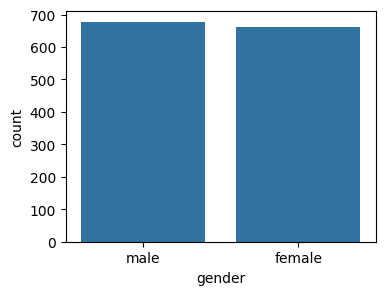

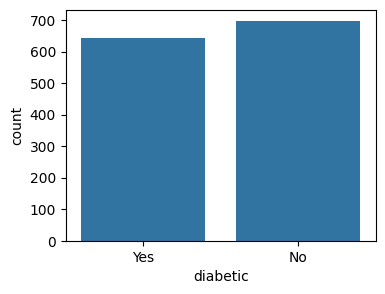

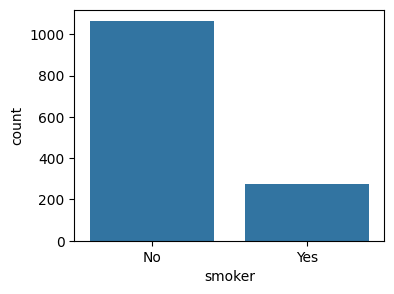

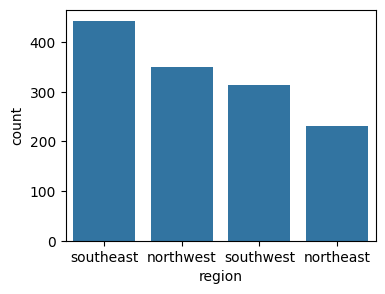

In [6]:
# inspect categorical columns
for column in cat_columns:
    plt.figure(figsize=(4, 3))
    sns.countplot(data=insurance_data, x=column) 
    plt.show()

In [7]:
# inspect average claim amount for each categorical feature
for i, col in enumerate(cat_columns): 
    print(insurance_data[[col, 'claim']].groupby(col).mean()) 
    print()

               claim
gender              
female  12569.578897
male    13919.790457

                 claim
diabetic              
No        13354.031991
Yes       13142.624346

               claim
smoker              
No       8421.121576
Yes     32050.231971

                  claim
region                 
northeast  16889.044719
northwest  11672.088453
southeast  13058.522664
southwest  12723.129841



In [8]:
num_columns = list(set(insurance_data.columns) - set(cat_columns))
num_columns.remove('PatientID')
num_columns.remove('claim')

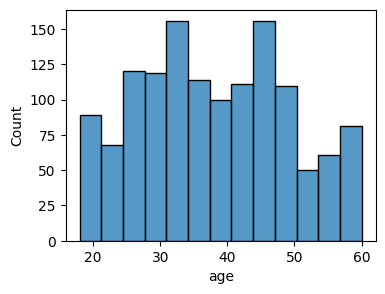

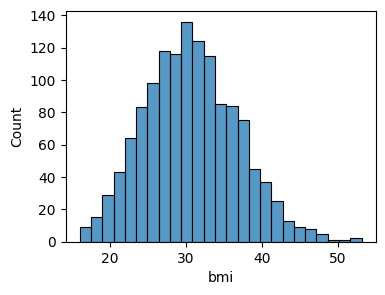

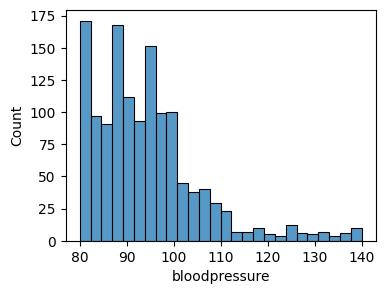

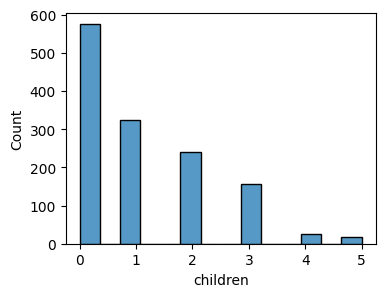

In [9]:
# inspect numerical columns
for column in num_columns:
    plt.figure(figsize=(4, 3))
    sns.histplot(data=insurance_data, x=column) 
    plt.show()

In [10]:
insurance_data_copy =  insurance_data.copy()
# inspect average claim amount for each numerical feature
for column in num_columns:
    insurance_data_copy[f'{column}_tertile'] = pd.qcut(insurance_data_copy[column], 3,
                                                  labels=False, duplicates='drop')
    print(insurance_data_copy[[f'{column}_tertile', 'claim']].groupby(f'{column}_tertile').mean()) 
    print()

                    claim
age_tertile              
0.0          13819.070481
1.0          13059.838986
2.0          12953.912719

                    claim
bmi_tertile              
0            10601.420935
1            12926.164922
2            16277.812466

                              claim
bloodpressure_tertile              
0                       9913.022175
1                      10136.017565
2                      20654.446216

                         claim
children_tertile              
0                 12473.137478
1                 14847.398705



In [11]:
insurance_data.isna().sum()

PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

In [12]:
# Replace NaN values with a string for categorical features
insurance_data[cat_columns] = insurance_data[cat_columns].fillna('missing')

# Splitting the data

In [13]:
features = insurance_data.drop(['claim', 'PatientID'], axis=1) # dropping target col and ID col
target = insurance_data['claim']

X_train, X_val, Y_train, Y_val = train_test_split( 
    features, target, random_state=2024, test_size=0.2) 

X_train.shape, X_val.shape 

((1072, 8), (268, 8))

# Model build

In [14]:
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [15]:
# simple model
model = CatBoostRegressor(loss_function='RMSE',
                          cat_features=cat_columns,
                          verbose=0) 

## Hyperparameter tuning

In [16]:
# Define the parameter distribution
param_dist = {
    'iterations': randint(100, 500), # to avoid overfitting
    'depth': randint(1, 8), # due to small sample size
    'learning_rate': loguniform(0.01, 0.2),
    'l2_leaf_reg': randint(1, 10),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255)
}

In [17]:
# Perform random search
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=3,
                                   scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, Y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'bagging_temperature': 0.9385527090157502, 'border_count': 161, 'depth': 4, 'iterations': 376, 'l2_leaf_reg': 1, 'learning_rate': 0.024878734419814436}
Best score:  -5311.542553125782


In [18]:
best_model = random_search.best_estimator_

In [19]:
train_pred = best_model.predict(X_train)
train_rmse = (np.sqrt(mean_squared_error(Y_train, train_pred)))
train_r2 = r2_score(Y_train, train_pred)

test_pred = best_model.predict(X_val)
test_rmse = (np.sqrt(mean_squared_error(Y_val, test_pred)))
test_r2 = r2_score(Y_val, test_pred)
print('Train RMSE: {:.2f}'.format(train_rmse),
      '\nTest RMSE: {:.2f}'.format(test_rmse))
print('Train R2: {:.4f}'.format(train_r2),
      '\nTest R2: {:.4f}'.format(test_r2))

Train RMSE: 4848.94 
Test RMSE: 5226.19
Train R2: 0.8398 
Test R2: 0.8117


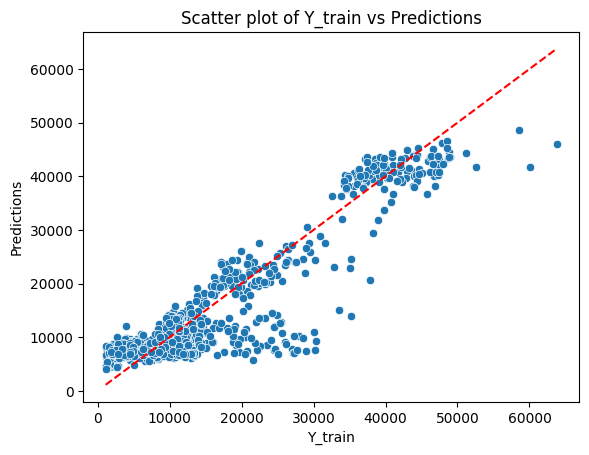

In [20]:
# plot predictions against actual values for train and test
sns.scatterplot(x=Y_train, y=train_pred)
plt.xlabel('Y_train')
plt.ylabel('Predictions')
plt.title('Scatter plot of Y_train vs Predictions')
# Adding diagonal line with slope of 1
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='--')
plt.show()

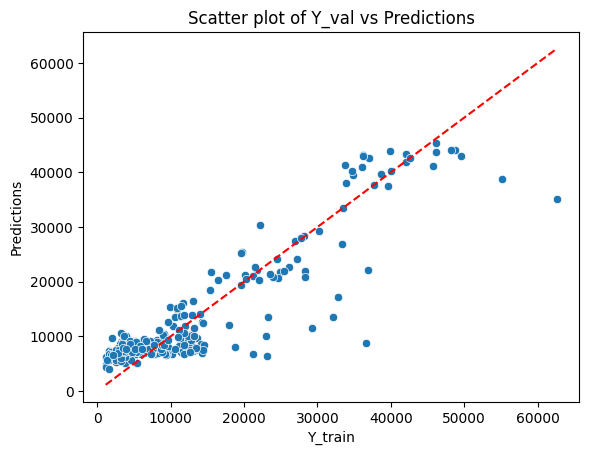

In [21]:
# plot predictions against actual values for train and test
sns.scatterplot(x=Y_val, y=test_pred)
plt.xlabel('Y_train')
plt.ylabel('Predictions')
plt.title('Scatter plot of Y_val vs Predictions')
# Adding diagonal line with slope of 1
plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], color='red', linestyle='--')
plt.show()

In [22]:
feature_importance_values = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance_values))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
# Print or visualize the sorted feature importances
feature_names = [feature for feature, importance in sorted_feature_importances]
importances = [importance for feature, importance in sorted_feature_importances]
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

smoker: 73.06794366373042
bmi: 16.743619854328998
bloodpressure: 6.355863165731807
region: 1.6305024672078885
children: 1.089544940061718
age: 0.8783610569872604
gender: 0.14991176498529987
diabetic: 0.08425308696659713


Text(0.5, 0, 'CatBoost Feature Importance')

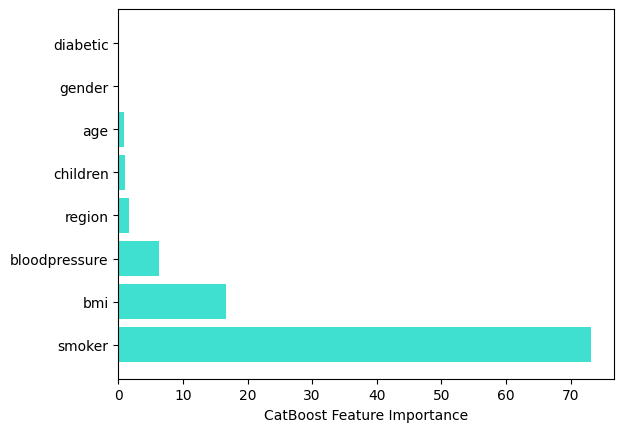

In [23]:
plt.barh(feature_names, importances, 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [24]:
num_corr = X_train[num_columns].corrwith(Y_train)

In [25]:
from scipy.stats import chi2_contingency

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Calculate Cramér's V with target column
cat_corr = {}
for column in cat_columns:
    cat_corr[column] = cramers_v(X_train[column], Y_train)

In [27]:
num_corr

age             -0.035837
bmi              0.189069
bloodpressure    0.535628
children         0.060474
dtype: float64

In [28]:
cat_corr

{'gender': 0.04323377011671162,
 'diabetic': 0.04323377011671162,
 'smoker': 0.04323377011671162,
 'region': 0.061170375020661284}

It seems all but age have a negative correlation with insurance claim amount thus we can interpret, with the data we have that being a smoker, having a higher BMI and blood pressure all suggest a higher claim may be submitted.

In [29]:
# evaluate performance by deciles
true_train_decile = pd.qcut(Y_train, 10, labels=False, duplicates='drop')
pred_train_decile = pd.qcut(train_pred, 10, labels=False, duplicates='drop')

true_test_decile = pd.qcut(Y_val, 10, labels=False, duplicates='drop')
pred_test_decile = pd.qcut(test_pred, 10, labels=False, duplicates='drop')

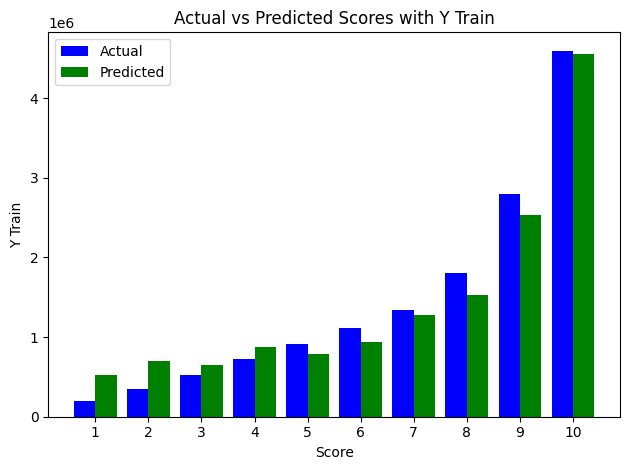

In [30]:
# Count occurrences of each score
score_counts = np.bincount(true_train_decile, weights=Y_train)
predicted_counts = np.bincount(pred_train_decile, weights=Y_train)

# Ensure both arrays have the same length (10 in this case)
max_len = max(len(score_counts), len(predicted_counts))
score_counts = np.pad(score_counts, (0, max_len - len(score_counts)), 'constant')
predicted_counts = np.pad(predicted_counts, (0, max_len - len(predicted_counts)), 'constant')

# Indices for x-axis (assuming scores from 1 to 10)
indices = np.arange(1, max_len + 1)

# Plotting
width = 0.4  # Width of the bars
plt.bar(indices - width/2, score_counts, width=width, label='Actual', color='b')
plt.bar(indices + width/2, predicted_counts, width=width, label='Predicted', color='g')

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Y Train')
plt.title('Actual vs Predicted Scores with Y Train')
plt.xticks(indices, indices)  # Set x-ticks as scores
plt.legend()

plt.tight_layout()
plt.show()

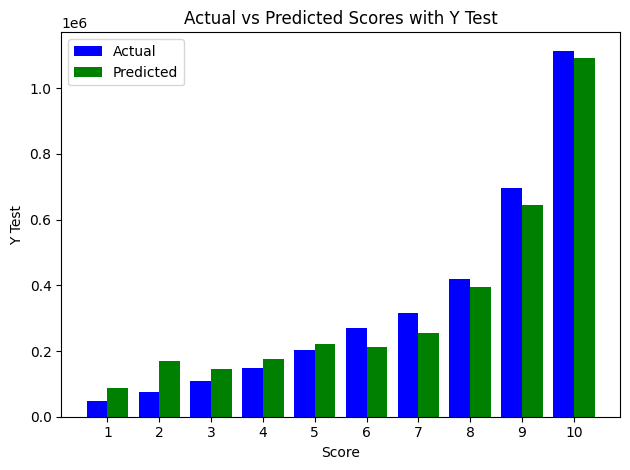

In [31]:
# Count occurrences of each score
score_counts = np.bincount(true_test_decile, weights=Y_val)
predicted_counts = np.bincount(pred_test_decile, weights=Y_val)

# Ensure both arrays have the same length (10 in this case)
max_len = max(len(score_counts), len(predicted_counts))
score_counts = np.pad(score_counts, (0, max_len - len(score_counts)), 'constant')
predicted_counts = np.pad(predicted_counts, (0, max_len - len(predicted_counts)), 'constant')

# Indices for x-axis (assuming scores from 1 to 10)
indices = np.arange(1, max_len + 1)

# Plotting
width = 0.4  # Width of the bars
plt.bar(indices - width/2, score_counts, width=width, label='Actual', color='b')
plt.bar(indices + width/2, predicted_counts, width=width, label='Predicted', color='g')

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Y Test')
plt.title('Actual vs Predicted Scores with Y Test')
plt.xticks(indices, indices)  # Set x-ticks as scores
plt.legend()

plt.tight_layout()
plt.show()